# Imports

In [20]:
# Import standard libraries for randomness, deep copying, and numerical operations
import random
import numpy as np
from copy import deepcopy

# Import libraries for image processing and data manipulation
from PIL import Image
import pandas as pd

# Import PyTorch core and utilities for deep learning
import torch
import torch.optim as optim  # Optimization algorithms
import torch.nn as nn  # Neural network modules
import torch.nn.functional as F  # Functional API for non-parametric operations

# Import PyTorch utilities for data loading and transformations
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler
from torchvision.transforms.v2 import Compose, ToImage, Normalize, ToPILImage, Resize, ToDtype

# Import dataset handling and learning rate schedulers
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, MultiStepLR, CyclicLR, LambdaLR

# Import visualization and web utilities
import matplotlib.pyplot as plt
import requests
import zipfile
import os
import errno

# Set matplotlib style for better visuals
plt.style.use('fivethirtyeight')

# Architecture class

In [21]:
import time

class Architecture(object):
    def __init__(self, model, loss_fn, optimizer, verbose=True, class_names=None):
        # Here we define the attributes of our class
        self.verbose=verbose
        self.class_names = class_names

        # We start by storing the arguments as attributes
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)
        if self.verbose:
            print(f"Model sent to {self.device}")

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model,
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()

        # for hook purposes
        self.handles = {}
        self.visualization = {}

        if self.verbose:
            print("Architecture created")

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
            if self.verbose:
                print(f"Model sent to {device}")
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

        if self.verbose:
            # Print train loader info
            print("Loaders set")
            if self.train_loader.dataset:
                print(f"Train dataset size: {len(self.train_loader.dataset)}")
            if self.train_loader.batch_size:
                print(f"Train batch size: {self.train_loader.batch_size}")

    def _make_train_step_fn(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer

        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn

    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn

    def _mini_batch(self, validation=False, verbose_mini_batch=None, mini_batch_report = 100):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None

        local_verbose = verbose_mini_batch and self.verbose

        if local_verbose:
            print("\tStarting mini-batch...")

        # Once the data loader and step function, this is the same
        # mini-batch loop we had before
        mini_batch_losses = []
        count = 0
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

            if local_verbose and count % mini_batch_report == 0:
                print(f"\t\tBatch {count}/{len(data_loader)}, loss: {mini_batch_loss}")

        loss = np.mean(mini_batch_losses)
        return loss

    # this function was updated in this class
    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        try:
            self.train_loader.sampler.generator.manual_seed(seed)
        except AttributeError:
            pass
        if self.verbose:
            print(f"Random seed set to {seed}")

    def train(self, n_epochs, seed=42, verbose=None, verbose_mini_batch=False, mini_batch_report=100, batch_report=10):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        local_verbose = self.verbose if verbose is None else verbose
        epoch_times = []

        if local_verbose:
            print("Starting training...")
            global_start = time.time()


        for epoch in range(n_epochs):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            epoch_start = time.time()
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False,
                                    verbose_mini_batch=verbose_mini_batch,
                                    mini_batch_report=mini_batch_report)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

            epoch_end = time.time()
            elapsed = epoch_end - epoch_start
            epoch_times.append(elapsed)

            is_first_epoch = epoch == 0
            is_last_epoch = epoch == n_epochs - 1

            has_report = is_first_epoch or is_last_epoch or (epoch + 1) % batch_report == 0

            if local_verbose and has_report:
                # Predict remaining duration
                avg_time = sum(epoch_times) / len(epoch_times)
                remaining_epochs = n_epochs - (epoch + 1)
                estimated_remaining_secs = avg_time * remaining_epochs
                mins, secs = divmod(int(estimated_remaining_secs), 60)

                print(
                    f"Epoch {self.total_epochs}/{n_epochs} | "
                    f"Train loss: {loss:.8f} | Val. loss: {val_loss:.8f} | "
                    f"Time: {elapsed:.2f}s | ETA: {mins}m {secs}s"
                )

        if local_verbose:
            total_time = time.time() - global_start
            mean_epoch_time = sum(epoch_times) / len(epoch_times)
            print(f"Training completed in {total_time:.2f} seconds.")
            print(f"Mean time per epoch: {mean_epoch_time:.2f} seconds.")

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)
        if self.verbose:
            print(f"Checkpoint saved to {filename}")

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training

        if self.verbose:
            print(f"Checkpoint loaded from {filename}")

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval()
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def count_parameters(self):
      return sum(p.numel() for p in self.model.parameters() if p.requires_grad)

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

    @staticmethod
    def _visualize_tensors(axs, x, y=None, yhat=None, layer_name='', title=None, class_names=None):
        # The number of images is the number of subplots in a row
        n_images = len(axs)
        # Gets max and min values for scaling the grayscale
        minv, maxv = np.min(x[:n_images]), np.max(x[:n_images])
        # For each image
        for j, image in enumerate(x[:n_images]):
            ax = axs[j]
            # Sets title, labels, and removes ticks
            if title is not None:
                ax.set_title(f'{title} #{j}', fontsize=12)
            shp = np.atleast_2d(image).shape
            ax.set_ylabel(
                f'{layer_name}\n{shp[0]}x{shp[1]}',
                rotation=0, labelpad=40
            )

            if class_names is not None:
                xlabel1 = '' if y is None else f'\nReal: {class_names[y[j]]}'
                xlabel2 = '' if yhat is None else f'\nPred.: {class_names[yhat[j]]}'
            else:
                xlabel1 = '' if y is None else f'\nLabel: {y[j]}'
                xlabel2 = '' if yhat is None else f'\nPredicted: {yhat[j]}'

            xlabel = f'{xlabel1}{xlabel2}'
            if len(xlabel):
                ax.set_xlabel(xlabel, fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])

            # Plots weight as an image
            ax.imshow(
                np.atleast_2d(image.squeeze()),
                cmap='gray',
                vmin=minv,
                vmax=maxv
            )
        return

    def visualize_filters(self, layer_name, **kwargs):
        try:
            # Gets the layer object from the model
            layer = self.model
            for name in layer_name.split('.'):
                layer = getattr(layer, name)
            # We are only looking at filters for 2D convolutions
            if isinstance(layer, nn.Conv2d):
                # Takes the weight information
                weights = layer.weight.data.cpu().numpy()
                # weights -> (channels_out (filter), channels_in, H, W)
                n_filters, n_channels, _, _ = weights.shape

                # Builds a figure
                size = (2 * n_channels + 2, 2 * n_filters)
                fig, axes = plt.subplots(n_filters, n_channels,
                                        figsize=size)
                axes = np.atleast_2d(axes)
                axes = axes.reshape(n_filters, n_channels)
                # For each channel_out (filter)
                for i in range(n_filters):
                    Architecture._visualize_tensors(
                        axes[i, :],
                        weights[i],
                        layer_name=f'Filter #{i}',
                        title='Channel',
                    )

                for ax in axes.flat:
                    ax.label_outer()

                fig.tight_layout()
                return fig
        except AttributeError:
            return

    def attach_hooks(self, layers_to_hook, hook_fn=None):
        # Clear any previous values
        self.visualization = {}
        # Creates the dictionary to map layer objects to their names
        modules = list(self.model.named_modules())
        layer_names = {layer: name for name, layer in modules[1:]}

        if hook_fn is None:
            # Hook function to be attached to the forward pass
            def hook_fn(layer, inputs, outputs):
                # Gets the layer name
                name = layer_names[layer]
                # Detaches outputs
                values = outputs.detach().cpu().numpy()
                # Since the hook function may be called multiple times
                # for example, if we make predictions for multiple mini-batches
                # it concatenates the results
                if self.visualization[name] is None:
                    self.visualization[name] = values
                else:
                    self.visualization[name] = np.concatenate([self.visualization[name], values])

        for name, layer in modules:
            # If the layer is in our list
            if name in layers_to_hook:
                # Initializes the corresponding key in the dictionary
                self.visualization[name] = None
                # Register the forward hook and keep the handle in another dict
                self.handles[name] = layer.register_forward_hook(hook_fn)

    def remove_hooks(self):
        # Loops through all hooks and removes them
        for handle in self.handles.values():
            handle.remove()
        # Clear the dict, as all hooks have been removed
        self.handles = {}

    def visualize_outputs(self, layers, n_images=10, y=None, yhat=None):
        layers = filter(lambda l: l in self.visualization.keys(), layers)
        layers = list(layers)
        shapes = [self.visualization[layer].shape for layer in layers]
        n_rows = [shape[1] if len(shape) == 4 else 1
                  for shape in shapes]
        total_rows = np.sum(n_rows)

        fig, axes = plt.subplots(total_rows, n_images,
                                figsize=(1.5*n_images, 1.5*total_rows))
        axes = np.atleast_2d(axes).reshape(total_rows, n_images)

        # Loops through the layers, one layer per row of subplots
        row = 0
        for i, layer in enumerate(layers):
            start_row = row
            # Takes the produced feature maps for that layer
            output = self.visualization[layer]

            is_vector = len(output.shape) == 2

            for j in range(n_rows[i]):
                Architecture._visualize_tensors(
                    axes[row, :],
                    output if is_vector else output[:, j].squeeze(),
                    y,
                    yhat,
                    layer_name=layers[i] \
                              if is_vector \
                              else f'{layers[i]}\nfil#{row-start_row}',
                    title='Image' if (row == 0) else None,
                    class_names=self.class_names
                )
                row += 1

        for ax in axes.flat:
            ax.label_outer()

        plt.tight_layout()
        return fig

    def correct(self, x, y, threshold=.5):
        self.model.eval()
        yhat = self.model(x.to(self.device))
        y = y.to(self.device)
        self.model.train()

        # We get the size of the batch and the number of classes
        # (only 1, if it is binary)
        n_samples, n_dims = yhat.shape
        if n_dims > 1:
            # In a multiclass classification, the biggest logit
            # always wins, so we don't bother getting probabilities

            # This is PyTorch's version of argmax,
            # but it returns a tuple: (max value, index of max value)
            _, predicted = torch.max(yhat, 1)
        else:
            n_dims += 1
            # In binary classification, we NEED to check if the
            # last layer is a sigmoid (and then it produces probs)
            if isinstance(self.model, nn.Sequential) and \
              isinstance(self.model[-1], nn.Sigmoid):
                predicted = (yhat > threshold).long()
            # or something else (logits), which we need to convert
            # using a sigmoid
            else:
                predicted = (F.sigmoid(yhat) > threshold).long()

        # How many samples got classified correctly for each class
        result = []
        for c in range(n_dims):
            n_class = (y == c).sum().item()
            n_correct = (predicted[y == c] == c).sum().item()
            result.append((n_correct, n_class))
        return torch.tensor(result)


    @staticmethod
    def loader_apply(loader, func, reduce='sum'):
        results = [func(x, y) for i, (x, y) in enumerate(loader)]
        results = torch.stack(results, axis=0)

        if reduce == 'sum':
            results = results.sum(axis=0)
        elif reduce == 'mean':
            results = results.float().mean(axis=0)

        return results

    @staticmethod
    def statistics_per_channel(images, labels):
        # NCHW
        n_samples, n_channels, n_height, n_weight = images.size()
        # Flatten HW into a single dimension
        flatten_per_channel = images.reshape(n_samples, n_channels, -1)

        # Computes statistics of each image per channel
        # Average pixel value per channel
        # (n_samples, n_channels)
        means = flatten_per_channel.mean(axis=2)
        # Standard deviation of pixel values per channel
        # (n_samples, n_channels)
        stds = flatten_per_channel.std(axis=2)

        # Adds up statistics of all images in a mini-batch
        # (1, n_channels)
        sum_means = means.sum(axis=0)
        sum_stds = stds.sum(axis=0)
        # Makes a tensor of shape (1, n_channels)
        # with the number of samples in the mini-batch
        n_samples = torch.tensor([n_samples]*n_channels).float()

        # Stack the three tensors on top of one another
        # (3, n_channels)
        return torch.stack([n_samples, sum_means, sum_stds], axis=0)

    @staticmethod
    def make_normalizer(loader):
        total_samples, total_means, total_stds = Architecture.loader_apply(loader, Architecture.statistics_per_channel)
        norm_mean = total_means / total_samples
        norm_std = total_stds / total_samples
        return Normalize(mean=norm_mean, std=norm_std)

    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

# Metrics

In [22]:
from sklearn.metrics import confusion_matrix
import itertools

def get_all_predictions(model, loader, device):
    all_preds = torch.tensor([]).to(device)
    all_labels = torch.tensor([]).to(device)
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            , dim=0
        )
        all_labels = torch.cat(
            (all_labels, labels)
            , dim=0
        )
    return all_preds.cpu(), all_labels.cpu()

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] ) * 100.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    plt.grid(False)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize and cm[i, j] == 0:
            continue
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return plt

# Generic Model Flow

In [23]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch.optim as optim  # Optimization algorithms

class ModelFlow():

    def __init__(self, model, train_loader, val_loader, model_name="model_instance", load_checkpoint_path=None):
        self.model = model
        self.model_name = model_name
        self.train_loader = train_loader
        self.val_loader = val_loader

        self.results_dir = f"results/{self.model_name}"
        os.makedirs(self.results_dir, exist_ok=True)
        print(f"Diretório de resultados: '{self.results_dir}'")

        torch.manual_seed(13)

        self.multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
        self.optimizer = optim.Adam(model.parameters(), lr=3e-4)

        self.class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

        self.arch = Architecture(self.model,
                                 self.multi_loss_fn,
                                 self.optimizer,
                                 class_names=self.class_names,
                                 verbose=True)
        self.arch.set_loaders(self.train_loader, self.val_loader)

        if load_checkpoint_path:
            print(f"Carregando checkpoint de: {load_checkpoint_path}")
            self.arch.load_checkpoint(load_checkpoint_path)

        print(f"Modelo '{self.model_name}' - Parâmetros: {self.arch.count_parameters()}")

    def train(self, epochs=10):
        print("Iniciando treinamento do modelo...")
        self.arch.train(epochs, verbose=True, verbose_mini_batch=False, batch_report=1)
        print("Treinamento completo!")

    def evaluate(self):
        print("\nAvaliando o modelo e salvando métricas...")
        # Gráfico de Perdas
        losses_fig = self.arch.plot_losses()
        losses_fig.savefig(f"{self.results_dir}/losses.png")
        plt.close(losses_fig)
        print(f"Gráfico de perdas salvo em '{self.results_dir}/losses.png'")

        # Matriz de Confusão
        with torch.no_grad():
            val_preds, val_labels = get_all_predictions(self.model, self.val_loader, self.arch.device)
        cm = confusion_matrix(val_labels.numpy(), val_preds.argmax(dim=1).numpy())
        fig_cm = plt.figure(figsize=(10,10))
        plot_confusion_matrix(cm, self.class_names, normalize=True, title=f"Matriz de Confusão - {self.model_name}")
        fig_cm.savefig(f"{self.results_dir}/confusion_matrix.png")
        plt.close(fig_cm)
        print(f"Matriz de confusão salva em '{self.results_dir}/confusion_matrix.png'")

        # Relatório de Classificação
        predicted_classes = val_preds.argmax(dim=1)
        report = classification_report(val_labels.numpy(), predicted_classes.numpy(), target_names=self.class_names, digits=4, output_dict=True)
        report_df = pd.DataFrame(report).transpose()
        report_df.to_csv(f"{self.results_dir}/classification_report.csv")
        print("Relatório de classificação:")
        print(report_df)
        print(f"Métricas salvas em '{self.results_dir}/'")

    def show_insides(self, filter_layers=[], layers_to_hook=[]):
        # Visualização de filtros
        for layer in filter_layers:
            fig = self.arch.visualize_filters(layer)
            if fig:
                fig.savefig(f"{self.results_dir}/filters_{layer}.png")
                plt.close(fig)
                print(f"Filtros da camada {layer} salvos em '{self.results_dir}/filters_{layer}.png'")

        # Pega um lote de imagens de validação
        images, labels = next(iter(self.val_loader))
        images_gpu = images.to(self.arch.device)

        # Anexa os hooks
        self.arch.attach_hooks(layers_to_hook)

        # Passa os dados pelo modelo para capturar as saídas
        with torch.no_grad():
            output = self.arch.model(images_gpu)

        predicted_classes = output.argmax(dim=1).cpu().numpy()

        # Adiciona as imagens originais para comparação no plot
        self.arch.visualization['images'] = images.cpu().numpy()

        # Visualiza as saídas capturadas
        fig_outputs = self.arch.visualize_outputs(layers_to_hook, y=labels.numpy(), yhat=predicted_classes)
        fig_outputs.savefig(f"{self.results_dir}/intermediate_outputs.png")
        plt.close(fig_outputs)
        print(f"Saídas intermediárias salvas em '{self.results_dir}/intermediate_outputs.png'")

        # Remove os hooks
        self.arch.remove_hooks()

        # Mantém apenas os outputs textuais informando sobre o salvamento
        print(f"\nFiguras de filtros e ativações salvas em '{self.results_dir}/'")

    def run(self, layers, epochs=10, skip_train=False):
        if not skip_train:
            self.train(epochs)

        checkpoint_path = f"{self.results_dir}/model_checkpoint.pth"
        self.arch.save_checkpoint(checkpoint_path)
        print(f"\nCheckpoint final salvo em: {checkpoint_path}")

        self.evaluate()
        self.show_insides(filter_layers=layers, layers_to_hook=layers)

# Import Fashion MNIST dataset

## Fashion-MNIST Dataset



This dataset is a collection of 70,000 grayscale images of clothing articles from the fashion retailer Zalando. It was created as a more challenging alternative to the original MNIST dataset of handwritten digits.

Key Features:

* **Images**: 28x28 pixels, grayscale.
* **Training Set**: 60,000 examples.
* **Test Set**: 10,000 examples.
* **Classes**: 10 different categories of clothing.

Classes:

The labels are integers from 0 to 9, corresponding to the following classes:

0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot

It shares the same image size, training/testing split, and overall structure as the original MNIST dataset, making it a "drop-in replacement" for many machine learning and computer vision tasks.

Original source https://github.com/zalandoresearch/fashion-mnist

## Code

In [24]:
import torchvision
import torchvision.transforms as transforms

# Download and load the training data
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True,
                                        transform=transforms.ToTensor())

# Download and load the test data
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True,
                                       transform=transforms.ToTensor())

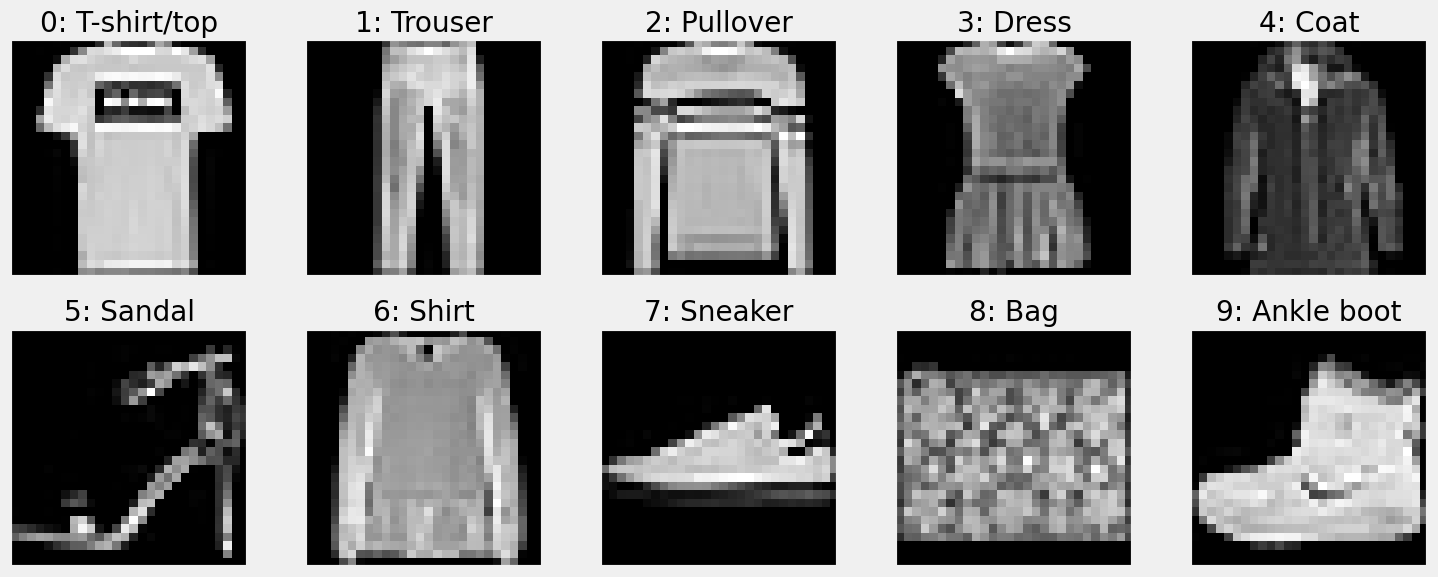

In [25]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

def figure_fashion_by_class(dataset):
    # These are the 10 class names for the dataset
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    # --- Find one image for each class ---
    images_by_class = {}
    for image, label in dataset:
        # If we haven't found an image for this class yet, store it
        if label not in images_by_class:
            images_by_class[label] = image
        # Stop when we have one for each of the 10 classes
        if len(images_by_class) == 10:
            break

    # --- Plot the images ---
    # Create a figure with a 2x5 grid of subplots
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))

    # Sort the images by class index (0-9) to keep the order consistent
    sorted_labels = sorted(images_by_class.keys())

    for i, ax in enumerate(axs.flat):
        label_index = sorted_labels[i]
        image_tensor = images_by_class[label_index]

        # Convert the tensor image to a PIL Image for displaying
        image_pil = ToPILImage()(image_tensor)

        # Get the class name using the label index
        title = class_names[label_index]

        # Display the image
        ax.imshow(image_pil, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"{label_index}: {title}")

    plt.tight_layout()
    plt.show()

# Call the function to display one example of each class
figure_fashion_by_class(trainset)

# Data loaders

In [26]:
import torch

# --- Standardization and DataLoader Creation ---

# 1. Load the training data to calculate the mean and standard deviation.
# This ensures we only use training data statistics to avoid data leakage.
temp_loader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset))
data = next(iter(temp_loader))
mean = data[0].mean()
std = data[0].std()
print(f"Calculated Mean: {mean:.4f}")
print(f"Calculated Std: {std:.4f}")

# 2. Calculate normalization.
composer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# 3. Reload the datasets using our new transformation pipeline.
trainset_norm = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=composer)
testset_norm = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=composer)

# 4. Create the final DataLoaders for training and validation.
train_loader = torch.utils.data.DataLoader(trainset_norm, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(testset_norm, batch_size=16, shuffle=False)

Calculated Mean: 0.2860
Calculated Std: 0.3530


# Model Base

In [27]:
class CNN2(nn.Module):
    def __init__(self, n_feature, in_channels=1, num_classes=10, p=0.3):
        super(CNN2, self).__init__()
        self.n_feature = n_feature
        self.p = p
        # Creates the convolution layers
        self.conv1 = nn.Conv2d(in_channels=in_channels,
                               out_channels=n_feature,
                               kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=n_feature,
                               out_channels=n_feature,
                               kernel_size=3)
        # Creates the linear layers
        # Where do this 5 * 5 come from?! Check it below
        self.fc1 = nn.Linear(n_feature * 5 * 5, 50)
        self.fc2 = nn.Linear(50, num_classes)
        # Creates dropout layers
        self.drop = nn.Dropout(self.p)

    def featurizer(self, x):
        # Featurizer
        # First convolutional block
        # 3@28x28 -> n_feature@26x26 -> n_feature@13x13
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # Second convolutional block
        # n_feature * @13x13 -> n_feature@11x11 -> n_feature@5x5
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # Input dimension (n_feature@5x5)
        # Output dimension (n_feature * 5 * 5)
        x = nn.Flatten()(x)
        return x

    def classifier(self, x):
        # Classifier
        # Hidden Layer
        # Input dimension (n_feature * 5 * 5)
        # Output dimension (50)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc1(x)
        x = F.relu(x)
        # Output Layer
        # Input dimension (50)
        # Output dimension (3)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc2(x)
        return x

    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x

# Model Base Flows

In [28]:
model_cnn2_7 = CNN2(n_feature=7, p=0.3, in_channels=1, num_classes=10)

mflow_7 = ModelFlow(model=model_cnn2_7, train_loader=train_loader, val_loader=val_loader, model_name='cnn2_7')
mflow_7.run(layers=['conv1', 'conv2'])

Diretório de resultados: 'results/cnn2_7'
Model sent to cuda
Architecture created
Loaders set
Train dataset size: 60000
Train batch size: 16
Modelo 'cnn2_7' - Parâmetros: 9828
Iniciando treinamento do modelo...
Random seed set to 42
Starting training...
Epoch 1/10 | Train loss: 0.88050974 | Val. loss: 0.58427529 | Time: 24.20s | ETA: 3m 37s
Epoch 2/10 | Train loss: 0.63816708 | Val. loss: 0.52531796 | Time: 24.21s | ETA: 3m 13s
Epoch 3/10 | Train loss: 0.58911124 | Val. loss: 0.49274784 | Time: 24.68s | ETA: 2m 50s
Epoch 4/10 | Train loss: 0.55884520 | Val. loss: 0.46563246 | Time: 24.45s | ETA: 2m 26s
Epoch 5/10 | Train loss: 0.54338683 | Val. loss: 0.45305204 | Time: 24.43s | ETA: 2m 1s
Epoch 6/10 | Train loss: 0.52554869 | Val. loss: 0.44374681 | Time: 24.15s | ETA: 1m 37s
Epoch 7/10 | Train loss: 0.51304412 | Val. loss: 0.42839735 | Time: 23.85s | ETA: 1m 12s
Epoch 8/10 | Train loss: 0.50159796 | Val. loss: 0.41832404 | Time: 23.80s | ETA: 0m 48s
Epoch 9/10 | Train loss: 0.49407938

In [29]:
model_cnn2 = CNN2(n_feature=5, p=0.3, in_channels=1, num_classes=10)

mflow = ModelFlow(model=model_cnn2, train_loader=train_loader, val_loader=val_loader, model_name='cnn2_5')
mflow.run(layers=['conv1', 'conv2'])


Diretório de resultados: 'results/cnn2_5'
Model sent to cuda
Architecture created
Loaders set
Train dataset size: 60000
Train batch size: 16
Modelo 'cnn2_5' - Parâmetros: 7090
Iniciando treinamento do modelo...
Random seed set to 42
Starting training...
Epoch 1/10 | Train loss: 0.90339681 | Val. loss: 0.57499800 | Time: 22.78s | ETA: 3m 24s
Epoch 2/10 | Train loss: 0.64612754 | Val. loss: 0.51932986 | Time: 23.07s | ETA: 3m 3s
Epoch 3/10 | Train loss: 0.59988326 | Val. loss: 0.49184304 | Time: 22.86s | ETA: 2m 40s
Epoch 4/10 | Train loss: 0.57369471 | Val. loss: 0.47410615 | Time: 23.06s | ETA: 2m 17s
Epoch 5/10 | Train loss: 0.55264102 | Val. loss: 0.46165605 | Time: 23.39s | ETA: 1m 55s
Epoch 6/10 | Train loss: 0.54753817 | Val. loss: 0.45264621 | Time: 23.19s | ETA: 1m 32s
Epoch 7/10 | Train loss: 0.53618633 | Val. loss: 0.44262220 | Time: 22.65s | ETA: 1m 8s
Epoch 8/10 | Train loss: 0.52653868 | Val. loss: 0.44237142 | Time: 22.79s | ETA: 0m 45s
Epoch 9/10 | Train loss: 0.51749361 

In [30]:
model_cnn2_3= CNN2(n_feature=3, p=0.3, in_channels=1, num_classes=10)

mflow_3 = ModelFlow(model=model_cnn2_3, train_loader=train_loader, val_loader=val_loader, model_name='cnn2_3')
mflow_3.run(layers=['conv1', 'conv2'])

Diretório de resultados: 'results/cnn2_3'
Model sent to cuda
Architecture created
Loaders set
Train dataset size: 60000
Train batch size: 16
Modelo 'cnn2_3' - Parâmetros: 4424
Iniciando treinamento do modelo...
Random seed set to 42
Starting training...
Epoch 1/10 | Train loss: 1.07989070 | Val. loss: 0.68932869 | Time: 22.45s | ETA: 3m 22s
Epoch 2/10 | Train loss: 0.80857326 | Val. loss: 0.63314324 | Time: 22.69s | ETA: 3m 0s
Epoch 3/10 | Train loss: 0.76727806 | Val. loss: 0.61064616 | Time: 22.97s | ETA: 2m 38s
Epoch 4/10 | Train loss: 0.73847971 | Val. loss: 0.59500342 | Time: 25.35s | ETA: 2m 20s
Epoch 5/10 | Train loss: 0.72014742 | Val. loss: 0.58285936 | Time: 22.85s | ETA: 1m 56s
Epoch 6/10 | Train loss: 0.70669165 | Val. loss: 0.56912378 | Time: 22.72s | ETA: 1m 32s
Epoch 7/10 | Train loss: 0.69934373 | Val. loss: 0.56097420 | Time: 22.69s | ETA: 1m 9s
Epoch 8/10 | Train loss: 0.68945315 | Val. loss: 0.55640864 | Time: 22.21s | ETA: 0m 45s
Epoch 9/10 | Train loss: 0.66198533 

# Generic CNN Model

In [31]:
import math

class GerenicCNN(nn.Module):
    def __init__(self,
                 in_channels,
                 num_classes,
                 input_size=28,
                 amnt_cov_layers=2,
                 cov_kernel_sizes=None,
                 cov_features=None,
                 max_pool_sizes=None,
                 amnt_fc_layers=2,
                 fc_sizes=None,
                 p=0.3):
        super(GerenicCNN, self).__init__()

        # Define defaults se não fornecidos
        if cov_kernel_sizes is None:
            cov_kernel_sizes = [3] * amnt_cov_layers
        if cov_features is None:
            cov_features = [16] * amnt_cov_layers
        if max_pool_sizes is None:
            max_pool_sizes = [2] * amnt_cov_layers
        if fc_sizes is None:
            fc_sizes = [50] * (amnt_fc_layers - 1)  # só intermediários

        # Validação
        self._validate_parameters(amnt_cov_layers,
                                 cov_kernel_sizes,
                                 cov_features,
                                 max_pool_sizes,
                                 amnt_fc_layers,
                                 fc_sizes)

        self.in_channels = in_channels
        self.num_classes = num_classes
        self.input_size = input_size
        self.amnt_cov_layers = amnt_cov_layers
        self.cov_kernel_sizes = cov_kernel_sizes
        self.cov_features = cov_features
        self.max_pool_sizes = max_pool_sizes
        self.amnt_fc_layers = amnt_fc_layers
        self.fc_sizes = fc_sizes
        self.p = p

        # Criação das camadas convolucionais e maxPool
        self.conv_layers = nn.ModuleList()
        self.max_pool_layers = nn.ModuleList()

        current_channels = in_channels
        current_size = input_size
        for i in range(amnt_cov_layers):

            if current_size <= 1:
                msg = f'Não será possível criar a camada convolucional {i}, '
                msg += "pois não será possível aplicar MaxPool de pelo menos 2."
                raise ValueError(msg)

            self.conv_layers.append(
                nn.Conv2d(
                    in_channels=current_channels,
                    out_channels=cov_features[i],
                    kernel_size=cov_kernel_sizes[i]
                )
            )

            self.max_pool_layers.append(
                nn.MaxPool2d(
                    kernel_size=max_pool_sizes[i]
                )
            )
            conv_out_size, out_size = self._compute_next_dims(current_size, cov_kernel_sizes[i], max_pool_sizes[i])

            print(f'conv{i}', end=' - ')
            print(f'in_size: {current_size}x{current_size}', end='\n\t')
            print(f'in_channels: {current_channels}', end='\n\t')
            print(f'out_channels: {cov_features[i]}', end='\n\t')
            print(f'kernel_size: {cov_kernel_sizes[i]}', end='\n\t')
            print(f'conv_out_size: {conv_out_size}x{conv_out_size}', end='\n\t')
            print(f'maxpool_kernel_size: {max_pool_sizes[i]}', end='\n\t')
            print(f'out_size (after max pool): {out_size}x{out_size}')


            current_channels = cov_features[i]
            current_size = out_size

            if current_size < 1:
                msg = f'Erro! Saída da camada convolucional {i} calculada com dimensão 0'
                raise ValueError(msg)


        # Calcula flattened_dim para o fc
        # Criar um tensor de exemplo para calcular a dimensão flattened
        with torch.no_grad():
            dummy_input = torch.randn(1, in_channels, input_size, input_size)
            dummy_output = self.featurizer(dummy_input)
            self.flattened_dim = dummy_output.numel() // dummy_output.shape[0]


        # Criação das camadas fully connected
        self.fc_layers = nn.ModuleList()

        full_fc_sizes = [self.flattened_dim] + self.fc_sizes + [num_classes]

        for i in range(amnt_fc_layers):
            print(f'fc{i} - in: {full_fc_sizes[i]} - out: {full_fc_sizes[i + 1]}')
            self.fc_layers.append(
                nn.Linear(
                    in_features=full_fc_sizes[i],
                    out_features=full_fc_sizes[i + 1]
                )
            )

        self.drop = nn.Dropout(self.p)

    def _validate_parameters(self, amnt_cov_layers, cov_kernel_sizes, cov_features, max_pool_sizes,
                        amnt_fc_layers, fc_sizes):
        assert len(cov_kernel_sizes) == amnt_cov_layers, \
            f"'cov_kernel_sizes' deve ter {amnt_cov_layers} elementos, mas tem {len(cov_kernel_sizes)}."
        assert len(cov_features) == amnt_cov_layers, \
            f"'cov_features' deve ter {amnt_cov_layers} elementos, mas tem {len(cov_features)}."
        assert len(max_pool_sizes) == amnt_cov_layers, \
            f"'max_pool_sizes' deve ter {amnt_cov_layers} elementos, mas tem {len(max_pool_sizes)}."
        assert len(fc_sizes) == (amnt_fc_layers - 1), \
            f"'fc_sizes' deve ter {amnt_fc_layers - 1} elementos, mas tem {len(fc_sizes)}."


    def _compute_next_dims(self, current_dim, kernel_size, max_pool_size):

        # Cálculo é [(w - k + 2p) / s] + 1
        # Por padrão, o padding é 0 e o stride é 1
        # Então o cálculo fica = [(w - k) / 1] + 1
        conv_dim = (current_dim - kernel_size) + 1


        # Por padrão, o padding é 0 e o stride é o kernel size
        # Então o cálculo fica = [(w - k) / k] + 1
        # = [(w / k) - 1] + 1
        # = w / k
        after_pool_dim = conv_dim / max_pool_size

        # Arredonda para baixo
        after_pool_dim = math.floor(after_pool_dim)
        return conv_dim, after_pool_dim

    def featurizer(self, x):
        # for i, conv_layer in enumerate(self.conv_layers):
        #     x = conv_layer(x)
        #     x = F.relu(x)
        #     x = F.max_pool2d(x, kernel_size=self.max_pool_sizes[i])
        # x = torch.flatten(x, 1)  # flatten exceto a batch dimension

        for conv_layer, max_pool_layer in zip(self.conv_layers, self.max_pool_layers):
            x = conv_layer(x)
            x = F.relu(x)
            x = max_pool_layer(x)

        return x


    def classifier(self, x):
        x = torch.flatten(x, 1)
        for i, fc_layer in enumerate(self.fc_layers):
            if self.p > 0 and i < len(self.fc_layers) - 1: # Apply dropout only before non-output layers
                x = self.drop(x)
            x = fc_layer(x)
            # Aplica ReLU em todas as camadas, exceto a última
            if i < len(self.fc_layers) - 1:
                x = F.relu(x)
        return x

    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x

In [34]:
example_dicts = [

    #  CNN2 equivalente
    {
        "in_channels": 1,
        "num_classes": 10,
        "input_size": 28,
        "amnt_cov_layers": 2,
        "cov_kernel_sizes": [3, 3],
        "cov_features": [5, 5],
        "max_pool_sizes": [2, 2],
        "amnt_fc_layers": 2,
        "fc_sizes": [50],
        "p": 0.3
    },

    # Rede mais profunda
    {
        "in_channels": 1,
        "num_classes": 10,
        "input_size": 28,
        "amnt_cov_layers": 3,
        "cov_kernel_sizes": [3, 3, 3],
        "cov_features": [8, 16, 32],
        "max_pool_sizes": [2, 2, 2],
        "amnt_fc_layers": 3,
        "fc_sizes": [100, 50],
        "p": 0.3
    },

    # Rede Pequena
    {
        "in_channels": 1,
        "num_classes": 10,
        "input_size": 28,
        "amnt_cov_layers": 1,
        "cov_kernel_sizes": [5],
        "cov_features": [4],
        "max_pool_sizes": [2],
        "amnt_fc_layers": 2,
        "fc_sizes": [20],
        "p": 0.3
    },

    # Rede Muitos FC
    {
        "in_channels": 1,
        "num_classes": 10,
        "input_size": 28,
        "amnt_cov_layers": 2,
        "cov_kernel_sizes": [3, 3],
        "cov_features": [5, 5],
        "max_pool_sizes": [2, 2],
        "amnt_fc_layers": 10,
        "fc_sizes": [int(1024 + i * (25 - 1024) / (9 - 1)) for i in range(9)],
        "p": 0.3
    },

]


# Other Models Flows

In [35]:
model_generic_0 = GerenicCNN(**example_dicts[0])

mflow_generic_0 = ModelFlow(
    model=model_generic_0,
    train_loader=train_loader,
    val_loader=val_loader,
    model_name='generic_0'
)

mflow_generic_0.run(
    layers=[f'conv_layers.{i}' for i in range(model_generic_0.amnt_cov_layers)]
)


conv0 - in_size: 28x28
	in_channels: 1
	out_channels: 5
	kernel_size: 3
	conv_out_size: 26x26
	maxpool_kernel_size: 2
	out_size (after max pool): 13x13
conv1 - in_size: 13x13
	in_channels: 5
	out_channels: 5
	kernel_size: 3
	conv_out_size: 11x11
	maxpool_kernel_size: 2
	out_size (after max pool): 5x5
fc0 - in: 125 - out: 50
fc1 - in: 50 - out: 10
Diretório de resultados: 'results/generic_0'
Model sent to cuda
Architecture created
Loaders set
Train dataset size: 60000
Train batch size: 16
Modelo 'generic_0' - Parâmetros: 7090
Iniciando treinamento do modelo...
Random seed set to 42
Starting training...
Epoch 1/10 | Train loss: 0.79236976 | Val. loss: 0.56087085 | Time: 24.74s | ETA: 3m 42s
Epoch 2/10 | Train loss: 0.59245773 | Val. loss: 0.51068630 | Time: 22.64s | ETA: 3m 9s
Epoch 3/10 | Train loss: 0.54753794 | Val. loss: 0.48120186 | Time: 22.53s | ETA: 2m 43s
Epoch 4/10 | Train loss: 0.51667132 | Val. loss: 0.45644677 | Time: 23.03s | ETA: 2m 19s
Epoch 5/10 | Train loss: 0.49907253 

In [36]:
model_generic_1 = GerenicCNN(**example_dicts[1])

mflow_generic_1 = ModelFlow(
    model=model_generic_1,
    train_loader=train_loader,
    val_loader=val_loader,
    model_name='generic_1'
)

mflow_generic_1.run(
    layers=[f'conv_layers.{i}' for i in range(model_generic_1.amnt_cov_layers)]
)


conv0 - in_size: 28x28
	in_channels: 1
	out_channels: 8
	kernel_size: 3
	conv_out_size: 26x26
	maxpool_kernel_size: 2
	out_size (after max pool): 13x13
conv1 - in_size: 13x13
	in_channels: 8
	out_channels: 16
	kernel_size: 3
	conv_out_size: 11x11
	maxpool_kernel_size: 2
	out_size (after max pool): 5x5
conv2 - in_size: 5x5
	in_channels: 16
	out_channels: 32
	kernel_size: 3
	conv_out_size: 3x3
	maxpool_kernel_size: 2
	out_size (after max pool): 1x1
fc0 - in: 32 - out: 100
fc1 - in: 100 - out: 50
fc2 - in: 50 - out: 10
Diretório de resultados: 'results/generic_1'
Model sent to cuda
Architecture created
Loaders set
Train dataset size: 60000
Train batch size: 16
Modelo 'generic_1' - Parâmetros: 14748
Iniciando treinamento do modelo...
Random seed set to 42
Starting training...
Epoch 1/10 | Train loss: 0.98034945 | Val. loss: 0.64316206 | Time: 25.10s | ETA: 3m 45s
Epoch 2/10 | Train loss: 0.70167934 | Val. loss: 0.58714514 | Time: 24.62s | ETA: 3m 18s
Epoch 3/10 | Train loss: 0.65003271 | V

In [37]:
model_generic_2 = GerenicCNN(**example_dicts[2])

mflow_generic_2 = ModelFlow(
    model=model_generic_2,
    train_loader=train_loader,
    val_loader=val_loader,
    model_name='generic_2'
)

mflow_generic_2.run(
    layers=[f'conv_layers.{i}' for i in range(model_generic_2.amnt_cov_layers)]
)


conv0 - in_size: 28x28
	in_channels: 1
	out_channels: 4
	kernel_size: 5
	conv_out_size: 24x24
	maxpool_kernel_size: 2
	out_size (after max pool): 12x12
fc0 - in: 576 - out: 20
fc1 - in: 20 - out: 10
Diretório de resultados: 'results/generic_2'
Model sent to cuda
Architecture created
Loaders set
Train dataset size: 60000
Train batch size: 16
Modelo 'generic_2' - Parâmetros: 11854
Iniciando treinamento do modelo...
Random seed set to 42
Starting training...
Epoch 1/10 | Train loss: 0.63731184 | Val. loss: 0.47137132 | Time: 21.30s | ETA: 3m 11s
Epoch 2/10 | Train loss: 0.47751705 | Val. loss: 0.42796864 | Time: 20.98s | ETA: 2m 49s
Epoch 3/10 | Train loss: 0.44133277 | Val. loss: 0.40466716 | Time: 20.81s | ETA: 2m 27s
Epoch 4/10 | Train loss: 0.41619955 | Val. loss: 0.38646013 | Time: 20.96s | ETA: 2m 6s
Epoch 5/10 | Train loss: 0.40261364 | Val. loss: 0.37273464 | Time: 20.78s | ETA: 1m 44s
Epoch 6/10 | Train loss: 0.38932839 | Val. loss: 0.36578814 | Time: 20.44s | ETA: 1m 23s
Epoch 7

In [38]:
model_generic_3 = GerenicCNN(**example_dicts[3])

mflow_generic_3 = ModelFlow(
    model=model_generic_3,
    train_loader=train_loader,
    val_loader=val_loader,
    model_name='generic_3'
)

mflow_generic_3.run(
    layers=[f'conv_layers.{i}' for i in range(model_generic_3.amnt_cov_layers)]
)

conv0 - in_size: 28x28
	in_channels: 1
	out_channels: 5
	kernel_size: 3
	conv_out_size: 26x26
	maxpool_kernel_size: 2
	out_size (after max pool): 13x13
conv1 - in_size: 13x13
	in_channels: 5
	out_channels: 5
	kernel_size: 3
	conv_out_size: 11x11
	maxpool_kernel_size: 2
	out_size (after max pool): 5x5
fc0 - in: 125 - out: 1024
fc1 - in: 1024 - out: 899
fc2 - in: 899 - out: 774
fc3 - in: 774 - out: 649
fc4 - in: 649 - out: 524
fc5 - in: 524 - out: 399
fc6 - in: 399 - out: 274
fc7 - in: 274 - out: 149
fc8 - in: 149 - out: 25
fc9 - in: 25 - out: 10
Diretório de resultados: 'results/generic_3'
Model sent to cuda
Architecture created
Loaders set
Train dataset size: 60000
Train batch size: 16
Modelo 'generic_3' - Parâmetros: 2955014
Iniciando treinamento do modelo...
Random seed set to 42
Starting training...
Epoch 1/10 | Train loss: 1.10237083 | Val. loss: 0.64863194 | Time: 33.58s | ETA: 5m 2s
Epoch 2/10 | Train loss: 0.68976186 | Val. loss: 0.57120443 | Time: 33.79s | ETA: 4m 29s
Epoch 3/1